## 1. Introduction & Overview

In [5]:
import pandas as pd
import ast

#Load raw data
RAW_PATH = '/Users/moo/Desktop/MSc Business Analytics/BEMM466 Business project/Data Preparation/arxiv_ai.csv'
df = pd.read_csv(RAW_PATH)

In [7]:
df.isna().sum()

authors                0
categories             0
comment             3864
doi                 8611
entry_id               0
journal_ref         7972
pdf_url                0
primary_category       0
published              0
summary                0
title                  0
updated                0
dtype: int64

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud, STOPWORDS
import re
from collections import Counter
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /Users/moo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
STOP_WORDS = set(stopwords.words('english')).union(STOPWORDS)
sns.set(style="whitegrid")

In [13]:
def safe_eval(val):
    try:
        return ast.literal_eval(val)
    except:
        return val

if 'authors' in df.columns and isinstance(df['authors'].iloc[0], str):
    df['authors'] = df['authors'].apply(safe_eval)

if 'categories' in df.columns and isinstance(df['categories'].iloc[0], str):
    df['categories'] = df['categories'].apply(safe_eval)

## 2. Initial Data Exploration

In [16]:
# 1. Data Overview
print(df.info())
print(df.head())
print(df.describe(include='all'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   authors           10000 non-null  object
 1   categories        10000 non-null  object
 2   comment           6136 non-null   object
 3   doi               1389 non-null   object
 4   entry_id          10000 non-null  object
 5   journal_ref       2028 non-null   object
 6   pdf_url           10000 non-null  object
 7   primary_category  10000 non-null  object
 8   published         10000 non-null  object
 9   summary           10000 non-null  object
 10  title             10000 non-null  object
 11  updated           10000 non-null  object
dtypes: object(12)
memory usage: 937.6+ KB
None
                                             authors categories  \
0            [arxiv.Result.Author('M. L. Ginsberg')]    [cs.AI]   
1             [arxiv.Result.Author('M. P. Wellman')]    [cs.AI]   

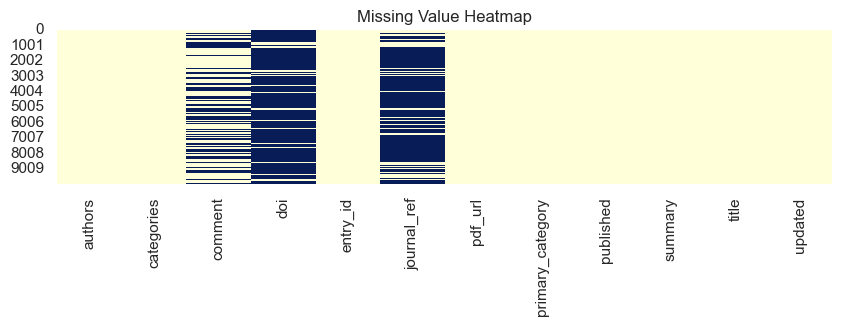

In [18]:
# 2. Missing Values Heatmap
plt.figure(figsize=(10, 2))
sns.heatmap(df.isnull(), cbar=False, cmap="YlGnBu")
plt.title("Missing Value Heatmap")
plt.show()

In [20]:
# 3. Duplicates count
df_tmp = df.copy()
for col in ['authors', 'categories']:
    if col in df_tmp.columns:
        df_tmp[col] = df_tmp[col].apply(lambda x: str(x) if isinstance(x, list) else x)

print("Duplicates:", df_tmp.duplicated().sum())

Duplicates: 0


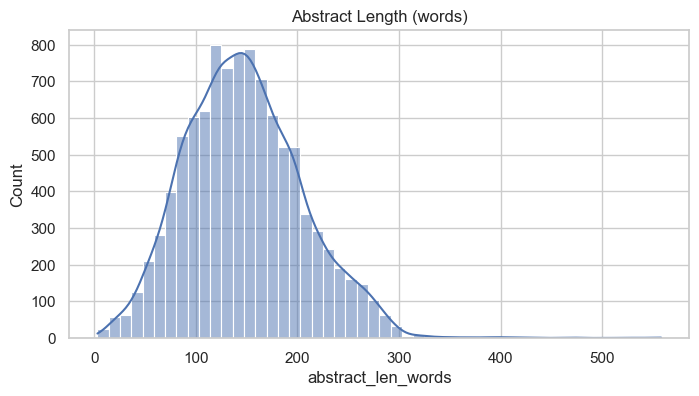

In [22]:
# 4. Abstract length distributions
df['abstract_len_words'] = df['summary'].astype(str).apply(lambda x: len(x.split()))
plt.figure(figsize=(8, 4))
sns.histplot(df['abstract_len_words'], bins=50, kde=True)
plt.title('Abstract Length (words)')
plt.show()

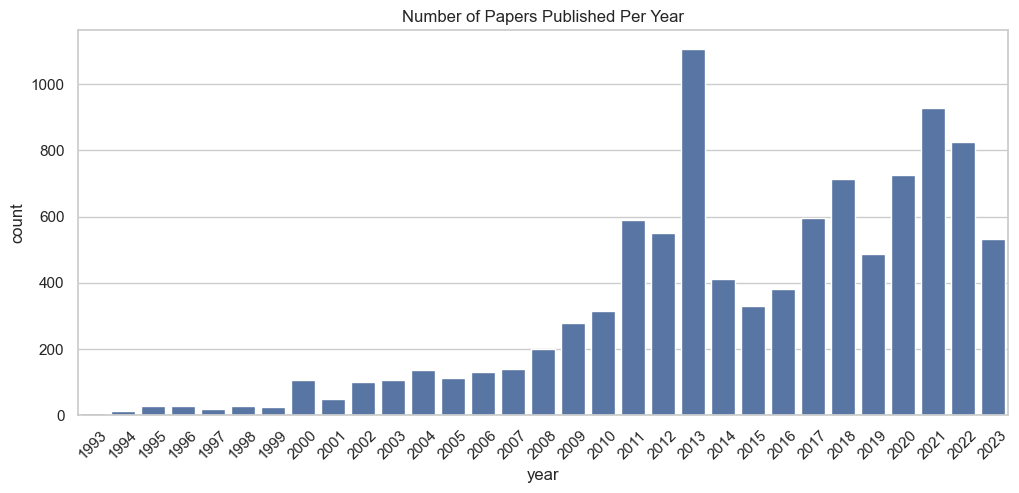

In [24]:
# 5. Year/Month temporal trend
df['published'] = pd.to_datetime(df['published'], errors='coerce')
df['year'] = df['published'].dt.year
df['month'] = df['published'].dt.month

plt.figure(figsize=(12, 5))
sns.countplot(data=df, x='year', order=sorted(df['year'].dropna().unique()))
plt.title('Number of Papers Published Per Year')
plt.xticks(rotation=45)
plt.show()

## 5. Temporal Trends Analysis

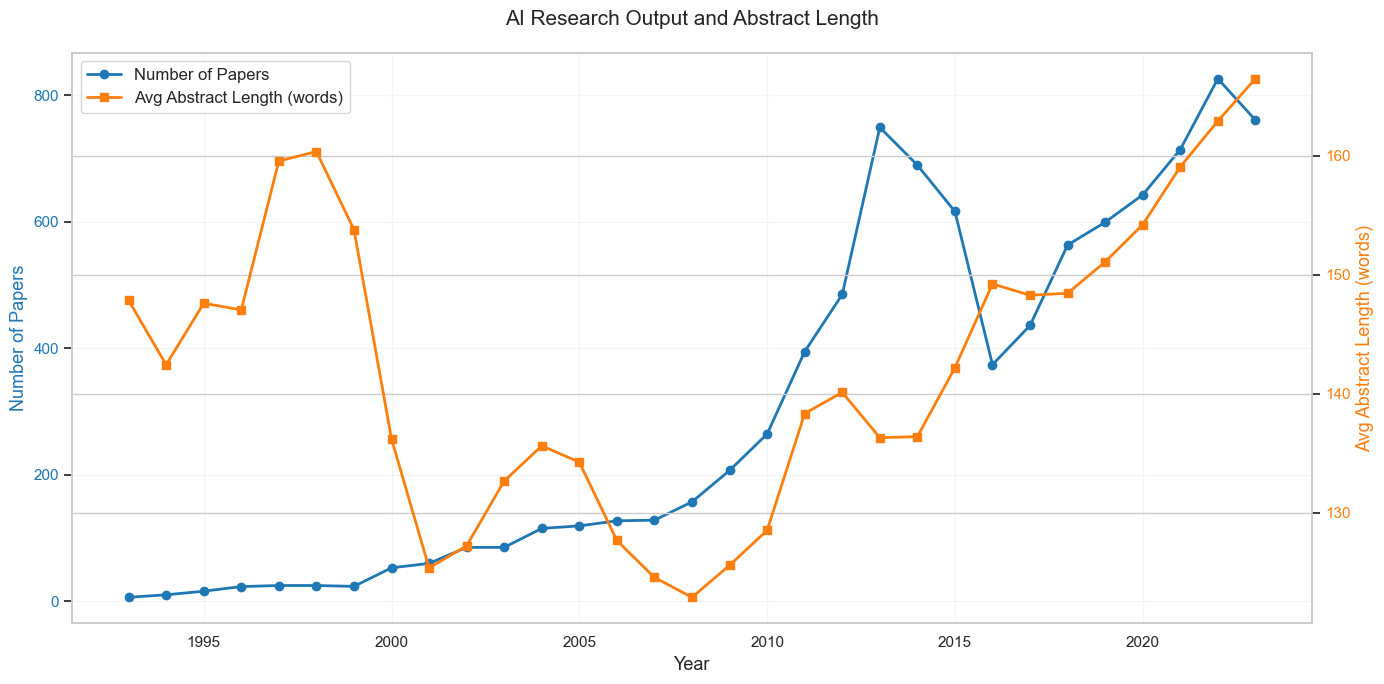

In [40]:
# import pandas as pd
import matplotlib.pyplot as plt

df['abstract_len_words_raw'] = df['summary'].astype(str).apply(lambda x: len(x.split()))


papers_per_year = df.groupby('year').size()
avg_len_per_year = df.groupby('year')['abstract_len_words_raw'].mean()

papers_rolling = papers_per_year.rolling(window=3, min_periods=1).mean()
len_rolling = avg_len_per_year.rolling(window=3, min_periods=1).mean()

fig, ax1 = plt.subplots(figsize=(14, 7))

color1 = '#1f77b4' 
color2 = '#ff7f0e' 

ax1.plot(papers_rolling.index, papers_rolling.values, color=color1, marker='o', linewidth=2, label='Number of Papers')
ax1.set_xlabel('Year', fontsize=13)
ax1.set_ylabel('Number of Papers', color=color1, fontsize=13)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(alpha=0.2)

ax2 = ax1.twinx()
ax2.plot(len_rolling.index, len_rolling.values, color=color2, marker='s', linewidth=2, label='Avg Abstract Length (words)')
ax2.set_ylabel('Avg Abstract Length (words)', color=color2, fontsize=13)
ax2.tick_params(axis='y', labelcolor=color2)

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left', fontsize=12)

plt.title('AI Research Output and Abstract Length', fontsize=15, pad=20)
plt.tight_layout()
plt.show()

In [29]:
import ast

def parse_authors(author_str):
    try:
        authors = ast.literal_eval(author_str)
        if isinstance(authors, list):
            return authors
        else:
            return [str(authors)]
    except Exception:
        return [str(author_str)]

df['authors_list'] = df['authors'].apply(parse_authors)

In [31]:
import re

def extract_names_from_string(author_str):
    parts = [p.strip() + ')' if not p.strip().endswith(')') else p.strip() for p in author_str.split('),')]
    names = []
    for part in parts:
        match = re.search(r"['\"](.*?)['\"]", part)
        if match:
            names.append(match.group(1))
    return names

df['author_names'] = df['authors'].apply(extract_names_from_string)
print(df['author_names'].head(20))

0                             [M. L. Ginsberg]
1                              [M. P. Wellman]
2                       [I. P. Gent, T. Walsh]
3     [F. Bergadano, D. Gunetti, U. Trinchero]
4             [J. C. Schlimmer, L. A. Hermens]
5      [M. Buchheit, F. M. Donini, A. Schaerf]
6                                 [N. Nilsson]
7                                 [C. X. Ling]
8                   [D. J. Cook, L. B. Holder]
9         [M. Koppel, R. Feldman, A. M. Segre]
10               [P. M. Murphy, M. J. Pazzani]
11         [A. Borgida, P. F. Patel-Schneider]
12                             [R. Sebastiani]
13     [A. J. Grove, J. Y. Halpern, D. Koller]
14           [T. Kitani, Y. Eriguchi, M. Hara]
15       [S. K. Murthy, S. Kasif, S. Salzberg]
16                  [S. Safra, M. Tennenholtz]
17                  [S. Soderland, Lehnert. W]
18                             [W. L. Buntine]
19        [S. Minton, J. Bresina, M. Drummond]
Name: author_names, dtype: object


In [33]:
df['n_authors'] = df['author_names'].apply(len)
print(df['n_authors'].describe())

count    10000.000000
mean         2.998700
std          2.254375
min          1.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         74.000000
Name: n_authors, dtype: float64


## 6. Author & Collaboration Trends

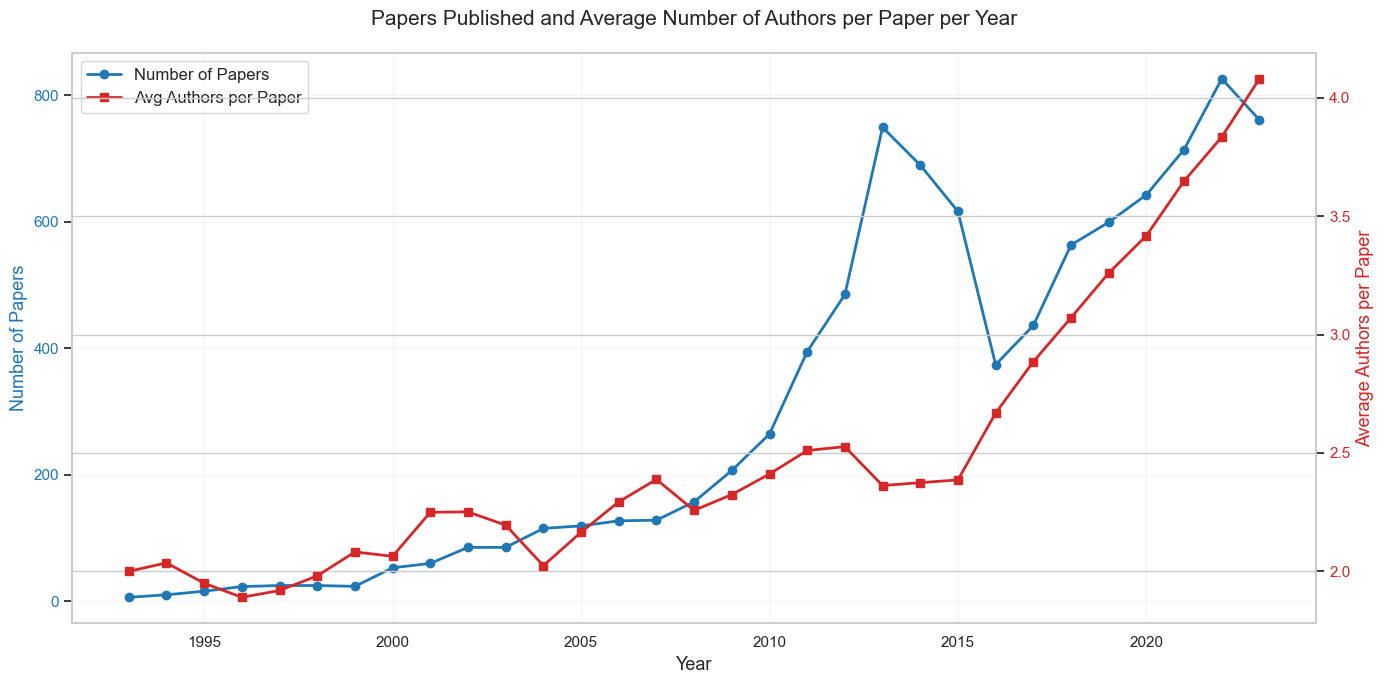

In [36]:
avg_authors_per_year = df.groupby('year')['n_authors'].mean()
papers_per_year = df.groupby('year').size()

# Smooth both series with a 3-year rolling average
papers_rolling = papers_per_year.rolling(window=3, min_periods=1).mean()
authors_rolling = avg_authors_per_year.rolling(window=3, min_periods=1).mean()

fig, ax1 = plt.subplots(figsize=(14,7))

color1 = 'tab:blue'
color2 = 'tab:red'

# Number of papers (primary y-axis)
ax1.plot(papers_rolling.index, papers_rolling.values, color=color1, marker='o', linewidth=2, label='Number of Papers')
ax1.set_ylabel('Number of Papers', color=color1, fontsize=13)
ax1.set_xlabel('Year', fontsize=13)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(alpha=0.2)

# Average authors per paper (secondary y-axis)
ax2 = ax1.twinx()
ax2.plot(authors_rolling.index, authors_rolling.values, color=color2, marker='s', linewidth=2, label='Avg Authors per Paper')
ax2.set_ylabel('Average Authors per Paper', color=color2, fontsize=13)
ax2.tick_params(axis='y', labelcolor=color2)

# Combined legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper left', fontsize=12)

plt.title('Papers Published and Average Number of Authors per Paper per Year', fontsize=15, pad=20)
plt.tight_layout()
plt.show()

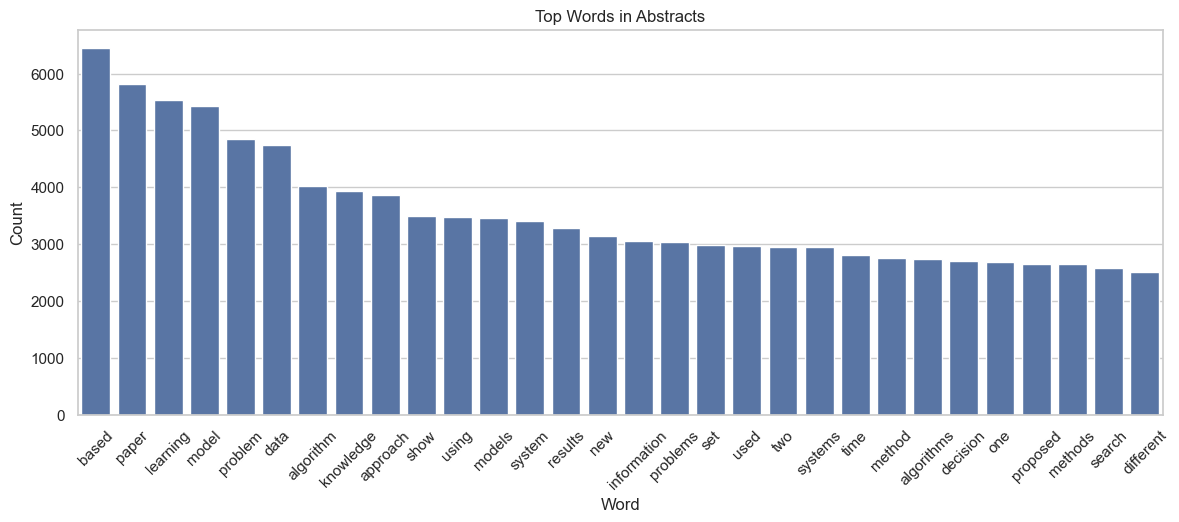

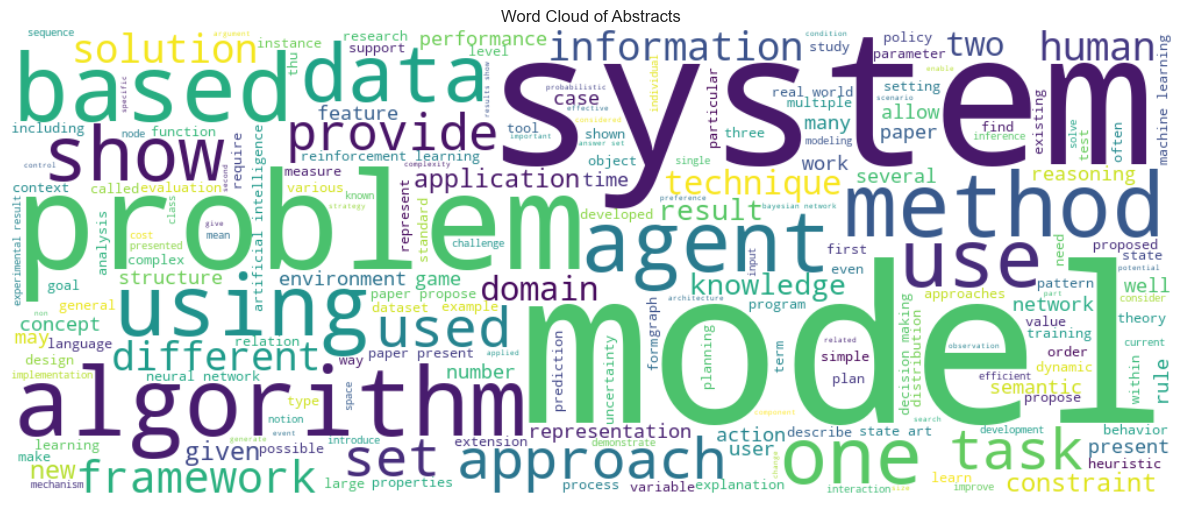

In [38]:
# 9. Word cloud and common words in abstracts
def clean_and_tokenize(text):
    words = re.findall(r'\b\w+\b', text.lower())
    return [w for w in words if w not in STOP_WORDS and len(w) > 2]
all_words = [word for abstract in df['summary'].dropna() for word in clean_and_tokenize(str(abstract))]
word_counts = Counter(all_words)
common_words = word_counts.most_common(30)

plt.figure(figsize=(14, 5))
sns.barplot(x=[w for w, c in common_words], y=[c for w, c in common_words])
plt.title('Top Words in Abstracts')
plt.xlabel('Word')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

wc = WordCloud(width=1000, height=400, background_color='white', stopwords=STOP_WORDS).generate(' '.join(all_words))
plt.figure(figsize=(15, 7))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Abstracts')
plt.show()

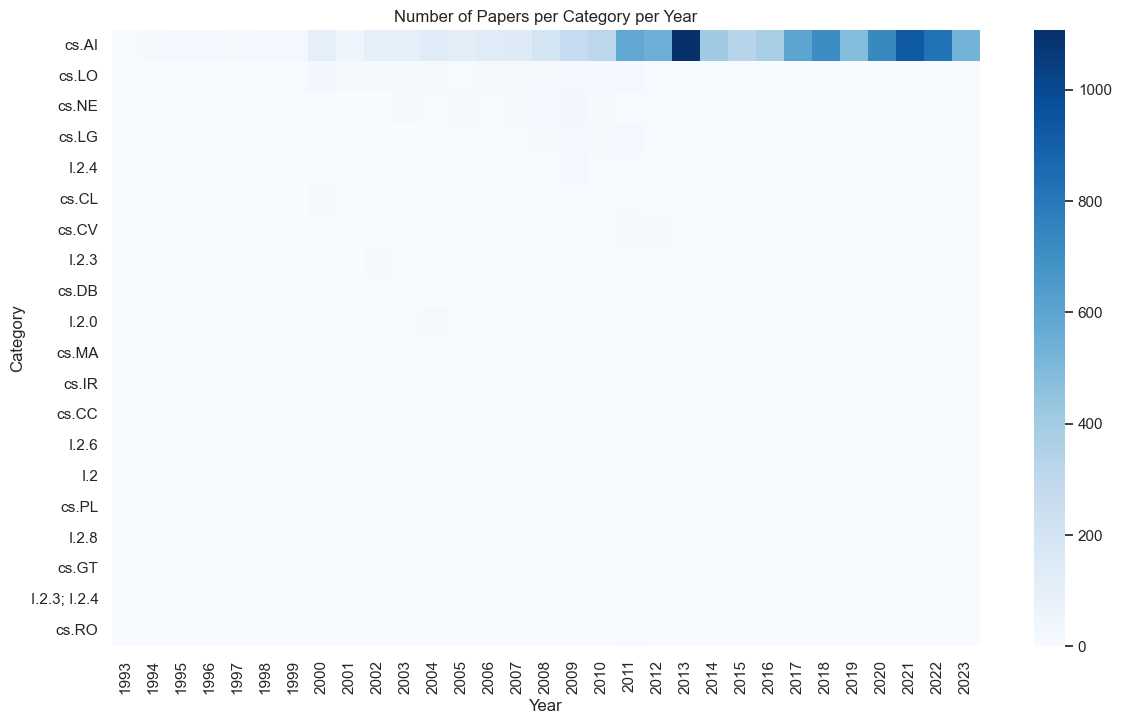

In [117]:
cat_years = []
for _, row in df.iterrows():
    if isinstance(row['categories'], list):
        for cat in row['categories']:
            cat_years.append((row['year'], cat))
cat_year_df = pd.DataFrame(cat_years, columns=['year', 'category'])
pivot = cat_year_df.pivot_table(index='category', columns='year', aggfunc=len, fill_value=0)
pivot_top = pivot.loc[pivot.sum(axis=1).sort_values(ascending=False).head(20).index]
plt.figure(figsize=(14, 8))
sns.heatmap(pivot_top, cmap='Blues')
plt.title('Number of Papers per Category per Year')
plt.xlabel('Year')
plt.ylabel('Category')
plt.show()

## 7. Category Analysis & Co-occurrence

In [120]:
from collections import Counter

co_counts = Counter()

for cats in df['categories']:
    # If row is a list and includes 'cs.AI', count the co-occurring categories
    if isinstance(cats, list) and 'cs.AI' in cats:
        for cat in cats:
            if cat != 'cs.AI':
                co_counts[cat] += 1

# Show top 10 categories co-occurring with cs.AI
print("Top categories co-occurring with cs.AI:")
for cat, count in co_counts.most_common(10):
    print(f"{cat}: {count}")

Top categories co-occurring with cs.AI:
cs.LO: 257
cs.NE: 168
cs.LG: 150
I.2.4: 120
cs.CL: 78
cs.CV: 73
I.2.3: 66
cs.DB: 61
I.2.0: 54
cs.MA: 50


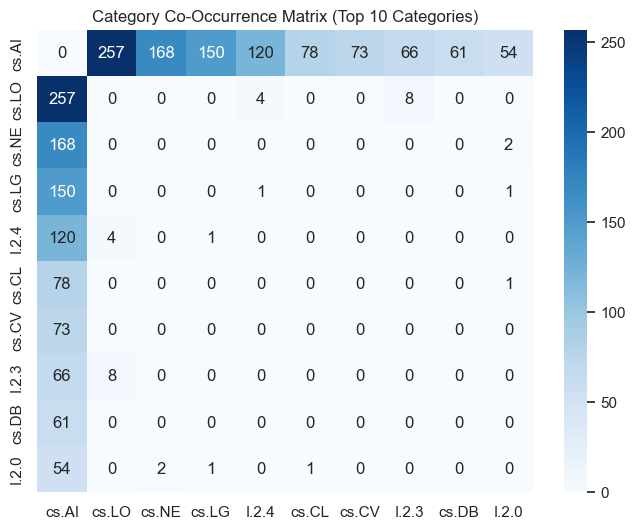

In [122]:
import itertools
# Flatten all categories and get most common
all_cats = [cat for cats in df['categories'] if isinstance(cats, list) for cat in cats]
top_cats = pd.Series(all_cats).value_counts().head(10).index

# Count co-occurrences among top categories
pair_counts = Counter()
for cats in df['categories']:
    if isinstance(cats, list):
        filtered = [c for c in cats if c in top_cats]
        for pair in itertools.combinations(sorted(filtered), 2):
            pair_counts[pair] += 1

co_mat = pd.DataFrame(0, index=top_cats, columns=top_cats)
for (a, b), count in pair_counts.items():
    co_mat.loc[a, b] = count
    co_mat.loc[b, a] = count  # symmetric

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.heatmap(co_mat, annot=True, fmt='d', cmap='Blues')
plt.title('Category Co-Occurrence Matrix (Top 10 Categories)')
plt.show()

## 7. Category Analysis & Co-occurrence

In [125]:
# 10. Top category pairs (interdisciplinary potential)
from itertools import combinations
cat_pairs = []
for cats in df['categories']:
    if isinstance(cats, list) and len(cats) > 1:
        cat_pairs += list(combinations(sorted(cats), 2))
cat_pair_counts = pd.Series(cat_pairs).value_counts().head(10)
print("Top category pairs (interdisciplinary):")
print(cat_pair_counts)

Top category pairs (interdisciplinary):
(cs.AI, cs.LO)    257
(cs.AI, cs.NE)    168
(cs.AI, cs.LG)    150
(I.2.4, cs.AI)    120
(cs.AI, cs.CL)     78
(cs.AI, cs.CV)     73
(I.2.3, cs.AI)     66
(cs.AI, cs.DB)     61
(I.2.0, cs.AI)     54
(cs.AI, cs.MA)     50
Name: count, dtype: int64


## 4. Text Normalization & Word Analysis

In [130]:
import re
import string
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = text.translate(str.maketrans('', '', string.digits + string.punctuation))
    words = [w for w in text.split() if w not in STOP_WORDS]
    words = [lemmatizer.lemmatize(w) for w in words if len(w) > 2]
    return ' '.join(words)

# Apply deep cleaning
df['summary_clean'] = df['summary'].astype(str).apply(preprocess_text)

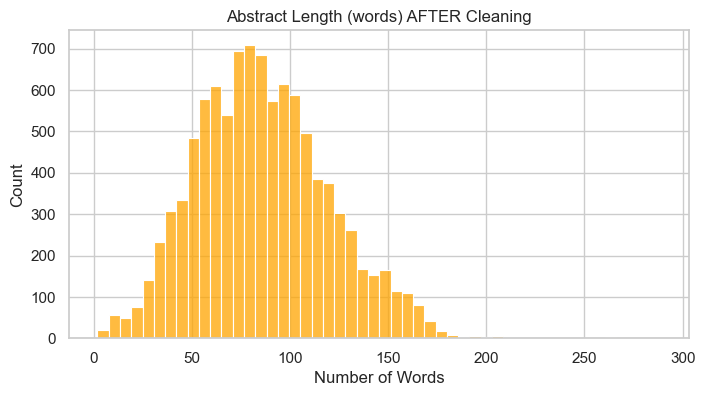

In [132]:
#visualise abstract length distribution after cleaning

df['abstract_len_words_clean'] = df['summary_clean'].apply(lambda x: len(x.split()))

plt.figure(figsize=(8, 4))
sns.histplot(df['abstract_len_words_clean'], bins=50, color='orange')
plt.title('Abstract Length (words) AFTER Cleaning')
plt.xlabel('Number of Words')
plt.ylabel('Count')
plt.show()

In [134]:
orig_n = len(df)
df = df[df['abstract_len_words_clean'] >= 10]
cleaned_n = len(df)
print(f"Removed {orig_n - cleaned_n} abstracts with fewer than 10 words after cleaning. Remaining: {cleaned_n}")

Removed 41 abstracts with fewer than 10 words after cleaning. Remaining: 9959


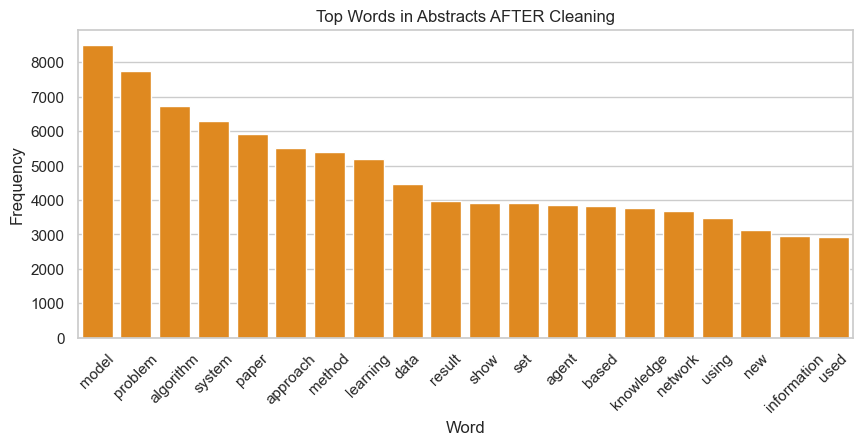

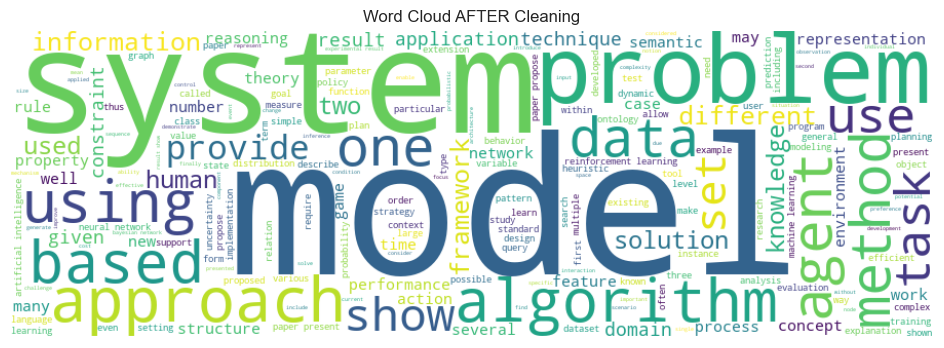

In [136]:
#common words and word cloud after cleaning

from collections import Counter

def get_word_counts(texts, stopwords, top_n=20):
    words = []
    for text in texts:
        words.extend([w.lower() for w in str(text).split() if w.lower() not in stopwords and len(w) > 2])
    return Counter(words).most_common(top_n)

# Bar plot: top 20 words after cleaning
common_words_clean = get_word_counts(df['summary_clean'], stopwords=STOP_WORDS, top_n=20)
plt.figure(figsize=(10, 4))
sns.barplot(x=[w for w, c in common_words_clean], y=[c for w, c in common_words_clean], color='darkorange')
plt.title('Top Words in Abstracts AFTER Cleaning')
plt.ylabel('Frequency')
plt.xlabel('Word')
plt.xticks(rotation=45)
plt.show()

# Word cloud after cleaning
wc_clean = WordCloud(width=900, height=300, stopwords=STOP_WORDS, background_color='white').generate(' '.join(df['summary_clean']))
plt.figure(figsize=(12, 4))
plt.imshow(wc_clean, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud AFTER Cleaning')
plt.show()

In [138]:
output_filename = 'arxiv_ai_cleaned_ready.csv'
df.to_csv(output_filename, index=False)
print(f"Cleaned data saved to {output_filename}")

Cleaned data saved to arxiv_ai_cleaned_ready.csv
